## 1. 데이터 선정
https://dacon.io/competitions/official/235647/overview/description

### 1-1. 문제 시나리오
- 정체되어 있는 선거 투표율을 높이고자 함

### 1-2. 문제 접근

- 투표율을 높이기 위해 어떤 방식의 투표 독려 메시지가 효과적일까?
- 국가 선거 투표자와 미투표자의 심리 성향은 어떻게 다를까?
- 심리 테스트 데이터를 분석하면 어떤 사람이 투표를 할지 안할지 예측할 수 있을까?

### 1-3. 가설 정의

- 마키아벨리즘 성향*이 높을 수록 투표할 가능성이 높을 것이다
- 개인의 성실성이 높을 수록 투표할 가능성이 높을 것이다.

*자신의 이익을 위해, 다른 사람이 이익을 추구하는 것을 저지하고, 다른 사람을 조종하는 것을 포함하는 사회적인 행동 전략

In [1]:
# !pip install --upgrade category_encoders
# !pip install eli5
# !pip install xgboost 
# !pip install lightgbm

In [2]:
# conda install lightgbm

In [3]:
# conda install -c conda-forge shap

In [40]:
#라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
import shap
from xgboost import XGBClassifier
from sklearn import metrics
from category_encoders import OrdinalEncoder, TargetEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from lightgbm import LGBMClassifier


In [5]:
#데이터 로드
train = pd.read_csv('./Data/vote/train.csv', index_col=0)
test = pd.read_csv('./Data/vote/test_x.csv', index_col=0)
submission = pd.read_csv('./Data/vote/sample_submission.csv', index_col=0)


## 2. 데이터 전처리
### 2-1. 결측치 및 이상치

In [6]:
#결측치, 데이터타입 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45532 entries, 0 to 45531
Data columns (total 77 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   QaA         45532 non-null  float64
 1   QaE         45532 non-null  int64  
 2   QbA         45532 non-null  float64
 3   QbE         45532 non-null  int64  
 4   QcA         45532 non-null  float64
 5   QcE         45532 non-null  int64  
 6   QdA         45532 non-null  float64
 7   QdE         45532 non-null  int64  
 8   QeA         45532 non-null  float64
 9   QeE         45532 non-null  int64  
 10  QfA         45532 non-null  float64
 11  QfE         45532 non-null  int64  
 12  QgA         45532 non-null  float64
 13  QgE         45532 non-null  int64  
 14  QhA         45532 non-null  float64
 15  QhE         45532 non-null  int64  
 16  QiA         45532 non-null  float64
 17  QiE         45532 non-null  int64  
 18  QjA         45532 non-null  float64
 19  QjE         45532 non-nul

In [7]:
#결측치, 데이터타입 확인
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11383 entries, 0 to 11382
Data columns (total 76 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   QaA         11383 non-null  float64
 1   QaE         11383 non-null  int64  
 2   QbA         11383 non-null  float64
 3   QbE         11383 non-null  int64  
 4   QcA         11383 non-null  float64
 5   QcE         11383 non-null  int64  
 6   QdA         11383 non-null  float64
 7   QdE         11383 non-null  int64  
 8   QeA         11383 non-null  float64
 9   QeE         11383 non-null  int64  
 10  QfA         11383 non-null  float64
 11  QfE         11383 non-null  int64  
 12  QgA         11383 non-null  float64
 13  QgE         11383 non-null  int64  
 14  QhA         11383 non-null  float64
 15  QhE         11383 non-null  int64  
 16  QiA         11383 non-null  float64
 17  QiE         11383 non-null  int64  
 18  QjA         11383 non-null  float64
 19  QjE         11383 non-nul

In [8]:
train.head()

,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,...,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
index,,,,,,,,,,,,,,,,,,,,,
0,3.0,363,4.0,1370,5.0,997,1.0,1024,2.0,1577,...,0,1,0,1,1,0,1,0,1,1
1,5.0,647,5.0,1313,3.0,3387,5.0,2969,1.0,4320,...,1,1,0,1,1,0,1,0,1,1
2,4.0,1623,1.0,1480,1.0,1021,4.0,3374,5.0,1333,...,1,1,0,1,1,1,1,0,1,1
3,3.0,504,3.0,2311,4.0,992,3.0,3245,1.0,357,...,0,0,0,0,1,0,1,0,1,1
4,1.0,927,1.0,707,5.0,556,2.0,1062,1.0,1014,...,1,1,1,1,1,0,1,1,1,1


In [9]:
train.loc[:,'age_group':'urban'].head()

,age_group,education,engnat,familysize,gender,hand,married,race,religion,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10,urban
index,,,,,,,,,,,,,,,,,,,,
0,30s,2,1,4,Female,1,3,White,Other,2,2,2,1,2,1,7,4,4,3,1
1,20s,4,2,3,Female,1,1,Asian,Hindu,1,1,0,0,1,2,3,4,0,4,3
2,30s,3,1,3,Male,1,2,White,Other,2,3,1,5,3,4,2,6,1,3,2
3,20s,4,2,0,Female,1,1,Asian,Hindu,2,4,1,1,1,3,1,3,1,3,3
4,20s,3,1,2,Male,1,2,White,Agnostic,1,1,1,6,0,2,0,6,2,6,1


In [10]:
train['age_group'].value_counts()


10s     14215
20s     14112
30s      7836
40s      5051
50s      2889
60s      1194
+70s      235
Name: age_group, dtype: int64

In [11]:
train['familysize'].value_counts()
#이상치가 좀 있음


2             17918
3             11256
1              6535
4              4907
5              1962
0              1217
6               838
7               387
8               221
9               126
10               59
11               39
12               21
13               11
14                9
15                8
44                3
17                3
21                2
20                2
16                2
999               1
2147483647        1
100               1
34                1
30                1
18                1
Name: familysize, dtype: int64

In [12]:
#자꾸 경고떠서 끔
pd.set_option('mode.chained_assignment',  None)

#10넘는 값들 10으로 대체하기
train['familysize'][train['familysize']>10]=10
test['familysize'][test['familysize']>10]=10
train['familysize'].value_counts()


2     17918
3     11256
1      6535
4      4907
5      1962
0      1217
6       838
7       387
8       221
10      165
9       126
Name: familysize, dtype: int64

### 2-2. 설문데이터 EDA

#### (1) 마키아벨리즘

- Q_A컬럼들은 마키아벨리즘이라는 성향을 판단하는 설문지로, 동의하는 정도에 따라 1에서 5까지로 답변한다.
- 본 데이터의 경우 1일 경우 점수가 높은 질문과 5일 경우 점수가 높은 질문이 섞여있다.

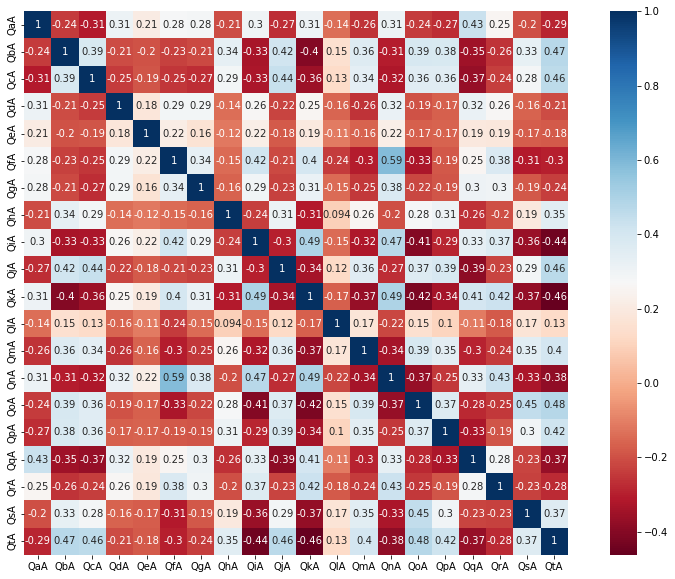

In [13]:
#마키아벨리즘 상관관계 확인
plt.figure(figsize = (15,10))
sns.heatmap(train.iloc[:,:40:2].corr(),square = True, annot = True,cmap='RdBu')
plt.show()

- 총 20개의 질문지의 상관관계를 시각화 해보면 정문항 10개/역문항 10개로 나뉘는 것을 알 수 있다
- 질문지의 내용을 살펴보면 정문항(1->5로 갈수록 마키아벨리즘 성향)과 역문항(5->1로 갈수록 마키아벨리즘 성향)을 구분할 수 있다.
 - Qb : The biggest difference between most criminals and other people is that the criminals are stupid enough to get caught.<br>
 >범죄자와 다른 사람들의 차이는 그저 범죄자들은 잡힐만큼 멍청했다는 것 뿐이다. (정문항)
 - Qc : Anyone who completely trusts anyone else is asking for trouble.
 >남을 전적으로 믿는 사람들은 스스로 화를 자초하는 것이다. (정문항)
- 시각화한 히트맵에서 Qb,Qc와 음의 상관관계를 가지는 역문항들은 정문항으로 전환해준 후 점수를 채점해야한다.

In [14]:
#역문항들을 역채점하기위해 전환 5->1 4->2, 3->3, 2->4, 1->5
def machi(df): 
    reverse_q = ['QaA', 'QdA', 'QeA', 'QfA', 'QgA','QiA', 'QkA', 'QnA', 'QqA', 'QrA']
    df[reverse_q] = 6 - df[reverse_q]
    #전환 후 모든 답변의 평균값으로 채점해서 피쳐 추가
    df['machi_score'] = df.iloc[:,:40:2].mean(axis=1)
    return df

train=machi(train)
test=machi(test)


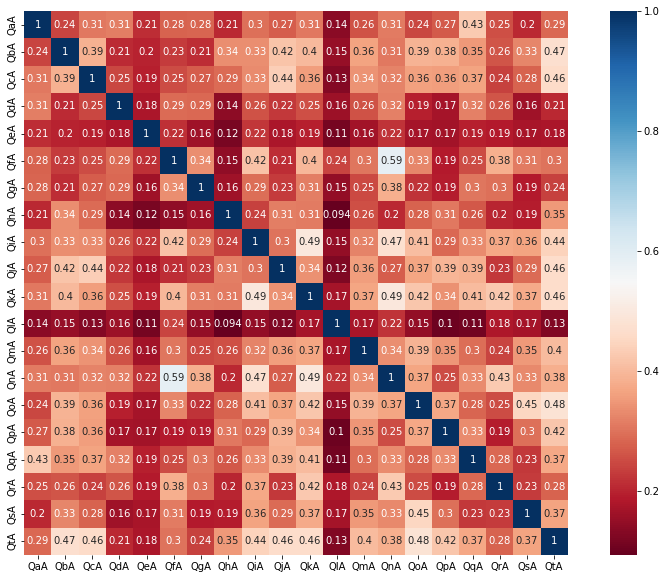

In [15]:
plt.figure(figsize = (15,10))
sns.heatmap(train.iloc[:,:40:2].corr(),square = True, annot = True, cmap='RdBu')
plt.show()

#모두 양의 상관관계를 이루게 된다. (20개의 설문지는 모두 '마키아벨리즘'이라는 하나의 성향을 판단하는 지표이므로)

/Users/h/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/h/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


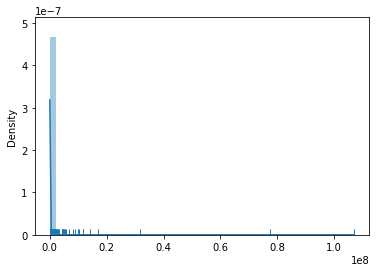

In [16]:
#20개의 각 질문별 응답시간 컬럼 분포 확인
sns.distplot(train.iloc[:,1:41:2],kde=True, rug=True)
plt.show()

In [17]:
#값들이 극단적이므로 로그변환 시켜주고 총합 컬럼 추가하기

def delay(df):
    df.iloc[:,1:41:2]= np.log1p(df.iloc[:,1:41:2])
    df['delay_sum']=df.iloc[:,1:41:2].T.sum()
    return df

train=delay(train)
test=delay(test)

/Users/h/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/h/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


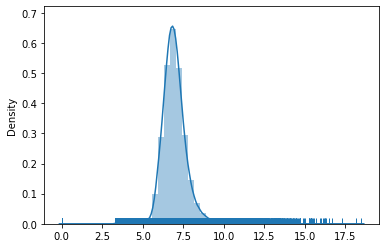

In [18]:
sns.distplot(train.iloc[:,1:41:2],kde=True, rug=True)
plt.show()

#### (2) big5 성격진단
> tipi항목 검사로 아래 5가지 성격요소를 측정함
- 성실성 : {3번 점수 + (8 - '8번 점수')} ÷ 2
- 우호성 : {7번 점수 + (8 - '2번 점수')} ÷ 2
- 정서적 안정성 : {9번 점수 + (8 - '4번 점수')} ÷ 2
- 개방성 : {5번 점수 + (8 - '10번 점수')} ÷ 2
- 외향성 : {1번 점수 + (8 - '6번 점수')} ÷ 2

In [19]:

def big5(df):
    #tipi검사 데이터 cleaning
    tp_list=['tp01','tp02','tp03','tp04','tp05','tp06','tp07','tp08','tp09','tp10']
    #무응답이 7로 되어있어 계산시 왜곡을 막기위해 null로 대체
    df[tp_list]=df[tp_list].replace(7,np.nan)
    #실제 검사지와 다르게 점수가 매겨져있어 원래대로 바꿈 6->1 5->2 ... 0->7
    df[tp_list]=7-df[tp_list]
    #결측치를 다시 평균값으로 대체
    df[tp_list]=df[tp_list].fillna(df[tp_list].mean())
    
    #채점 공식으로 big5유형측정
    df['tp_co']=(df['tp03']+8-(df['tp08']))/2
    df['tp_ag']=(df['tp07']+8-(df['tp02']))/2
    df['tp_em']=(df['tp09']+8-(df['tp04']))/2
    df['tp_op']=(df['tp05']+8-(df['tp10']))/2
    df['tp_ex']=(df['tp01']+8-(df['tp06']))/2
    
    #채점후 tipi검사지 드롭
    df = df.drop(df[tp_list],axis=1)
    return df

train=big5(train)
test=big5(test)



### 2-3 개인정보 및 기타 데이터 EDA



In [20]:
#기타 피쳐들 엔지니어링
def engineering(df):
  #실존하는 단어의 정의를 알고있다고 대답한 정도
  df['wr']=df.loc[:,'wr_01':'wr_13'].T.mean()
  #허구의 단어의 정의를 알고있다고 대답한 정도
  df['wf']=df.loc[:,'wf_01':'wf_03'].T.mean()
    
  #피쳐 엔지니어링에 사용한 컬럼들 드롭
  df = df.drop(df.iloc[:,:40],axis = 1)
  drop_val = ['wr_01','wr_02','wr_03','wr_04','wr_05','wr_06','wr_07','wr_08','wr_09',
              'wr_10','wr_11','wr_12','wr_13','wf_01','wf_02','wf_03']
  df = df.drop(drop_val,axis = 1)
  
  return df

train=engineering(train)
test=engineering(test)

In [21]:
#미투표자를 2에서 0으로 변경
train['voted']=train['voted'].replace(2,0)


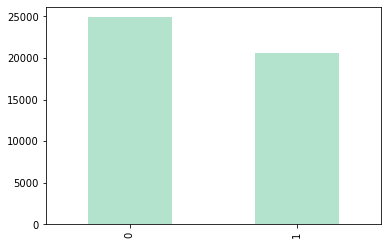

In [22]:
#타겟 분포 시각화
sns.set_palette("Pastel2")
train['voted'].value_counts().plot(kind='bar')
plt.show()

#미투표자가 더 많다

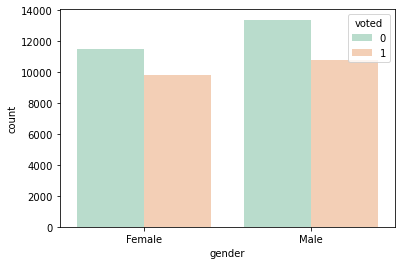

In [23]:
#성별별 타겟 분포 시각화

sns.countplot(data=train, x='gender', hue='voted')
plt.show()

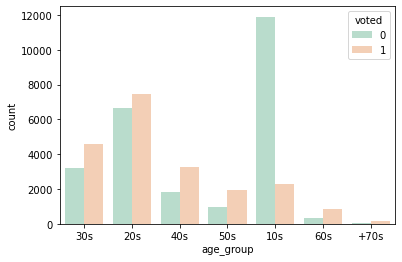

In [24]:
#연령대별 타겟 분포 시각화

sns.countplot(data=train, x='age_group', hue='voted')
plt.show()

#10대는 투표자가 적다. 투표권이 없는 10대들이 다수 포함된 것으로 보인다.


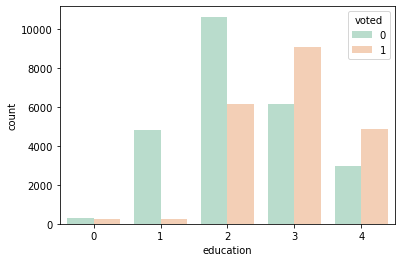

In [25]:
#학력별 타겟 분포 시각화

sns.countplot(data=train, x='education', hue='voted')
plt.show()

#'무응답','고졸 미만','고졸', '대학 재학', '대학 졸업' 순
#고학력일수록 투표자가 많은 것으로 보이나, 고졸미만(1)의 경우 투표권이 없는 10대가 다수 포함됐을 가능성 있음


In [26]:
#고졸미만 그룹의 연령대 확인
train[train['education']==1]['age_group'].value_counts()
#고졸미만 그룹의 경우 다수 10대인 것으로 확인됨

10s     4573
20s      207
30s      157
40s       80
50s       48
60s       14
+70s       9
Name: age_group, dtype: int64

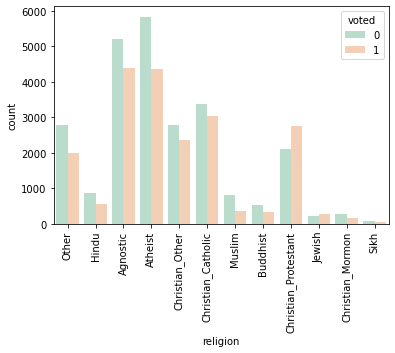

In [27]:
#종교별 타겟 분포 시각화
sns.countplot(data=train, x='religion', hue='voted')
plt.xticks(rotation=90)
plt.show()
#개신교가 투표율이 높다.

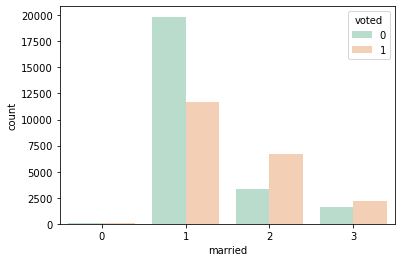

In [28]:
#혼인상태별 타겟 분포 시각화
sns.countplot(data=train, x='married', hue='voted')
plt.show()
#1=Never married, 2=Currently married, 3=Previously married, 0=Other
#기혼자, 혼인경험이 있는 경우 투표율이 높다.

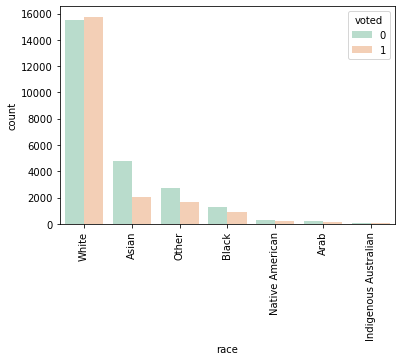

In [29]:
#인종별 타겟 분포 시각화
sns.countplot(data=train, x='race', hue='voted')
plt.xticks(rotation=90)
plt.show()
#백인의 투표율이 비교적 높다

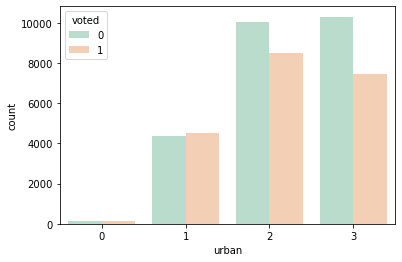

In [30]:
#유년기 거주지 유형별 타겟 분포 시각화
sns.countplot(data=train, x='urban', hue='voted')
plt.show()
#1=Rural (country side), 2=Suburban, 3=Urban (town, city), 0=무응답
#유년기를 시골에서 보낸 경우 비교적 투표율이 높다

## 3. 모델링

In [31]:
#object 값들 인코딩
encoder = LabelEncoder()
enc_list = ['age_group', 'gender', 'race', 'religion']
for i in enc_list:
  train[i] = encoder.fit_transform(train[i])
  test[i] = encoder.transform(test[i])

#age_group이 연령대에 비례하는 값으로 인코딩될수있도록 다시 맞춰줌. 0으로 인코딩된 70s를 7로 변경
train['age_group']=train['age_group'].replace(0,7)
test['age_group']=test['age_group'].replace(0,7)


In [32]:
#모델링을 위해 훈련데이터셋의 특성과 타겟 분리
target = 'voted'
X_train = train.drop([target], axis=1)
y_train = train[target]


In [33]:
#기준모델 만들기



base_model=LGBMClassifier(random_state=2)

base_model.fit(X_train, y_train)
print('훈련 정확도', base_model.score(X_train, y_train))

#기준모델 결과 저장
# submission.iloc[:,0]= pipe0.predict(test)
# submission.to_csv('submission_0.csv')


훈련 정확도 0.7279934990775718


In [43]:


#기준모델에서 하이퍼파라미터 튜닝 진행
dists = {
    'max_depth': [41,43,45,47,49,51],
    'min_child_samples': [7,9,11,13,15,17,19,21,23],
    'num_leaves': [23,25,27,29,31],
    'n_estimators': [300],
    'learning_rate': [0.01,0.02]
}

clf = RandomizedSearchCV(
    base_model, 
    param_distributions=dists, 
    n_iter=100, 
    cv=3,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);


Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [44]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('auc: ', clf.best_score_)


최적 하이퍼파라미터:  {'num_leaves': 29, 'n_estimators': 300, 'min_child_samples': 17, 'max_depth': 43, 'learning_rate': 0.02}
auc:  0.7683545943452531


In [45]:
lgbm=clf.best_estimator_
lgbm.fit(X_train, y_train)
print('훈련 정확도', lgbm.score(X_train, y_train))

submission.iloc[:,0]= lgbm.predict(test)
submission.to_csv('submission_1.csv')



훈련 정확도 0.7149038039181235


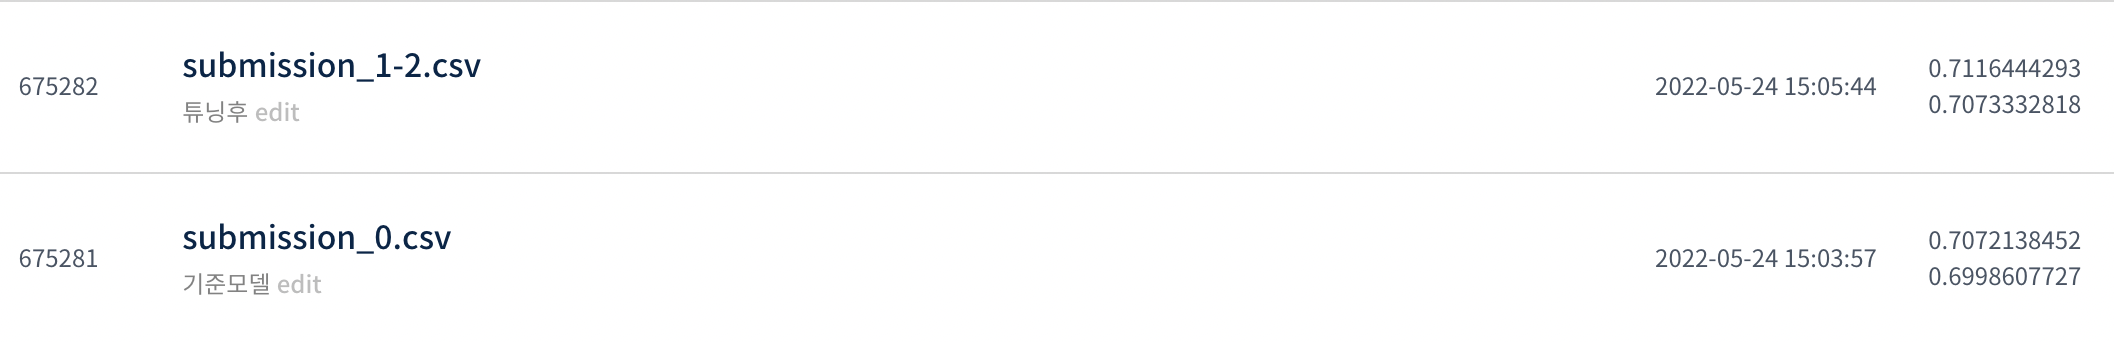

- 훈련 정확도는 낮아졌으나 테스트예측 제출결과 auc 소량 상승함

In [46]:

permuter = PermutationImportance(
    lgbm, # model
    scoring='roc_auc', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

permuter.fit(X_train, y_train);

feature_names=X_train.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

#해석
#왼손잡이인지 오른손잡이인지는 예측에 영향이 적다
#교육수준이 예측에 가장 많은 영향을 미친다.


hand           0.000516
gender         0.001796
tp_op          0.002011
tp_ag          0.002457
familysize     0.002819
urban          0.003072
wf             0.004309
tp_co          0.005526
tp_em          0.005567
wr             0.005755
engnat         0.006092
delay_sum      0.006878
tp_ex          0.006897
married        0.007066
machi_score    0.007760
religion       0.010404
race           0.030802
age_group      0.067237
education      0.071572
dtype: float64

In [47]:
eli5.show_weights(
    permuter, 
    top=None,
    feature_names=feature_names)

Weight,Feature
0.0716 ± 0.0021,education
0.0672 ± 0.0008,age_group
0.0308 ± 0.0012,race
0.0104 ± 0.0004,religion
0.0078 ± 0.0006,machi_score
0.0071 ± 0.0005,married
0.0069 ± 0.0007,tp_ex
0.0069 ± 0.0003,delay_sum
0.0061 ± 0.0004,engnat
0.0058 ± 0.0003,wr


In [48]:
pd.set_option('mode.chained_assignment',  None)
shap_values = shap.TreeExplainer(lgbm).shap_values(test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


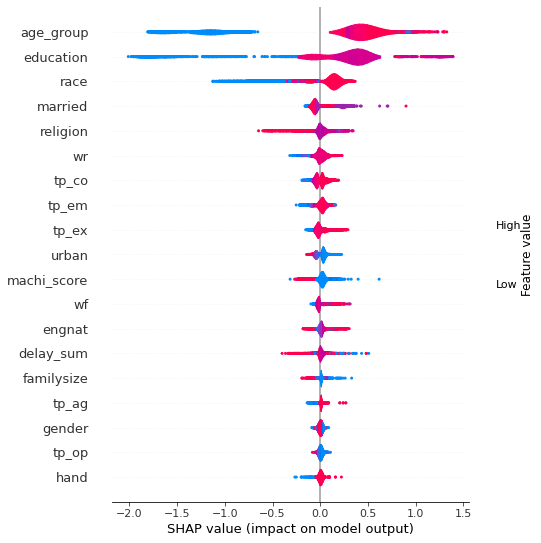

In [51]:
shap.summary_plot(shap_values[1], test,plot_type="violin")

#1(투표자)일 가능성에 영향을 끼친정도를 확인할 수 있다.


#### 위의 shap plot을 통해 1-3 에서 정의했던 가설을 살펴보면,
- 마키아벨리즘 성향이 높을 수록 투표할 가능성이 높을 것이다
 > 마키아벨리즘 성향(machi_score)이 높을 수록 투표할 가능성에 음의 영향을 주고 있으므로 틀렸다.
- 개인의 성실성이 높을 수록 투표할 가능성이 높을 것이다.
 > 성실성(tp_co)이 높을수록 투표할 가능성에 양의 영향을 주고 있으므로 옳다.